In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
PATH = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(PATH)

# Basic clean
df.columns = df.columns.str.strip()
print("Initial shape:", df.shape)
# Handle TotalCharges: blanks -> NaN -> numeric
df['TotalCharges'] = df['TotalCharges'].astype(str).str.strip()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges']).copy()

# Map Churn to 0/1
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1}).astype(int)

# Fix SeniorCitizen
if df['SeniorCitizen'].dtype != 'int64' and df['SeniorCitizen'].dtype != 'int32':

    if df['SeniorCitizen'].dtype == 'object':
        df['SeniorCitizen'] = df['SeniorCitizen'].map({'No':0,'Yes':1}).fillna(df['SeniorCitizen']).astype(int)
    else:
        df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

# Create ARPU column (TotalCharges / tenure) handling tenure==0
df['ARPU'] = df.apply(lambda r: r['TotalCharges'] / r['tenure'] if r['tenure'] > 0 else 0, axis=1)

# Convert appropriate object columns to category
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype('category')

print("After cleaning shape:", df.shape)
df.head(3)


Initial shape: (7043, 21)
After cleaning shape: (7032, 22)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ARPU
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,29.850000
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,55.573529
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,54.075000


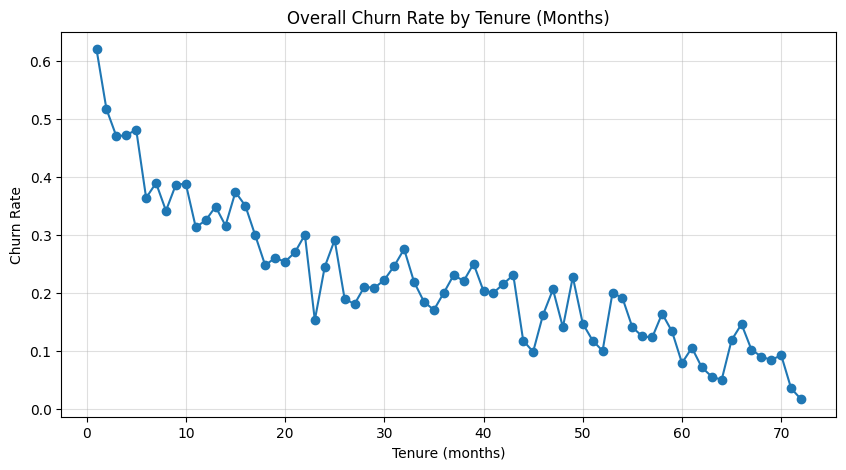

Overall churn rate (dataset): 26.58%
Top 5 tenure months by churn rate:
   tenure     Churn
0       1  0.619902
1       2  0.516807
4       5  0.481203
3       4  0.471591
2       3  0.470000


In [15]:
# Q1: Measure churn rate over time to understand how customer attrition trends are evolving and identify when intervention is most needed.
# Churn rate by tenure (months)
churn_by_tenure = df.groupby('tenure')['Churn'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(churn_by_tenure['tenure'], churn_by_tenure['Churn'], marker='o')
plt.title('Overall Churn Rate by Tenure (Months)')
plt.xlabel('Tenure (months)')
plt.ylabel('Churn Rate')
plt.grid(alpha=0.4)
plt.show()

print("Overall churn rate (dataset): {:.2%}".format(df['Churn'].mean()))
print("Top 5 tenure months by churn rate:")
print(churn_by_tenure.sort_values('Churn', ascending=False).head(5))


/tmp/ipython-input-2753015219.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention = df.groupby([category, 'tenure'])['Churn'].apply(lambda x: 1 - x.mean()).reset_index(name='Retention')


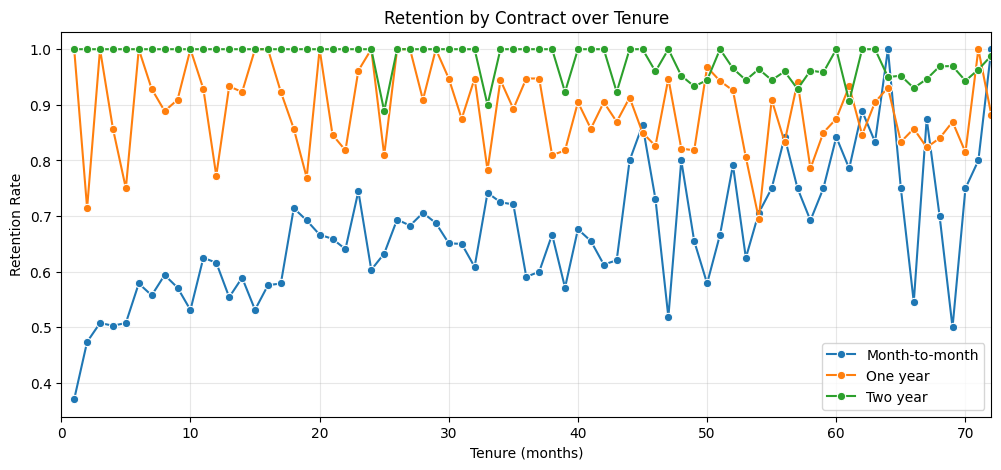

/tmp/ipython-input-2753015219.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention = df.groupby([category, 'tenure'])['Churn'].apply(lambda x: 1 - x.mean()).reset_index(name='Retention')


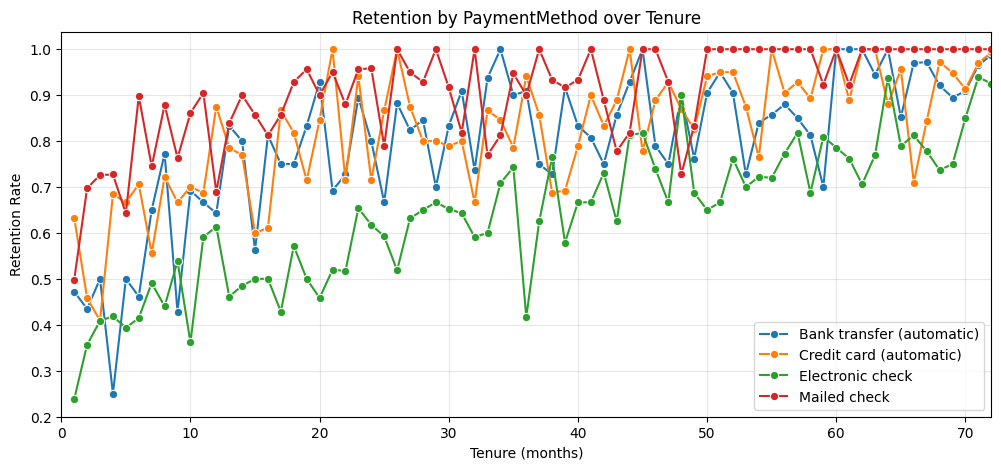

/tmp/ipython-input-2753015219.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention = df.groupby([category, 'tenure'])['Churn'].apply(lambda x: 1 - x.mean()).reset_index(name='Retention')


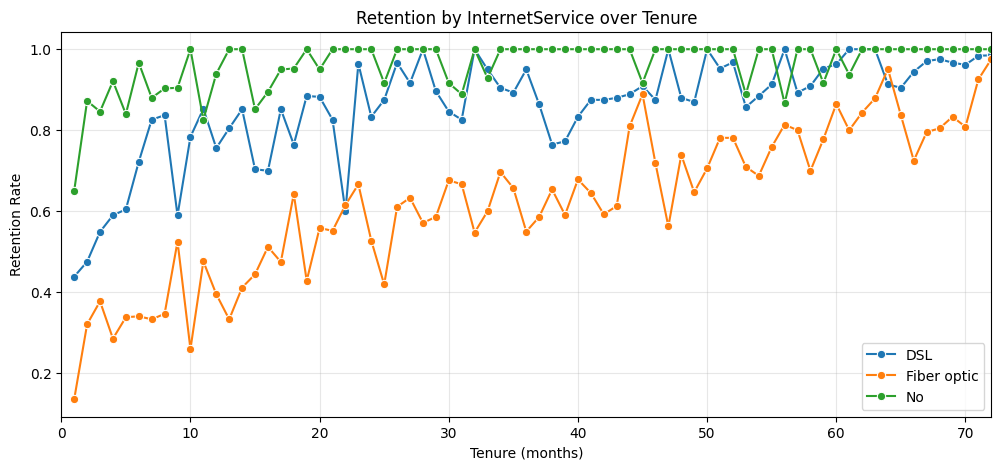

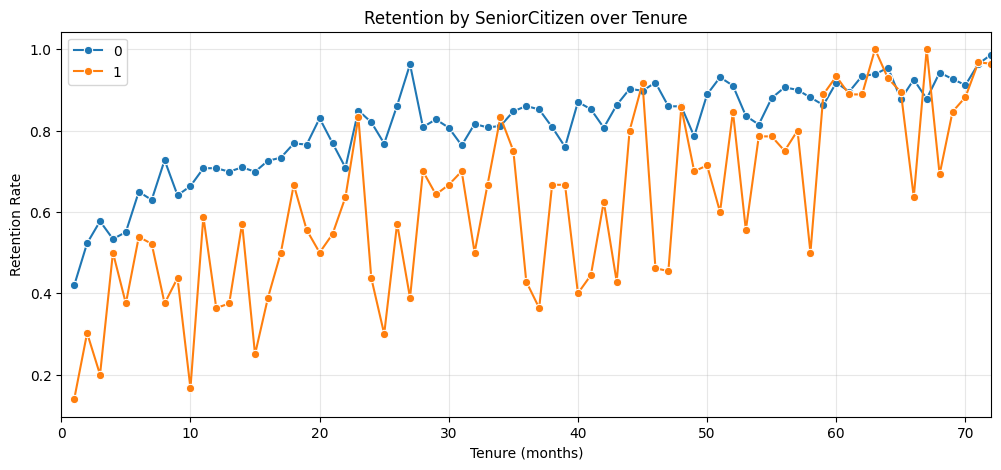

In [16]:
# Q2: Analyze retention across customer cohorts (by signup month, plan type, or region) to identify which segments are performing best and replicate their success.
# Retention (1 - churn) over tenure for different cohorts

def plot_retention(category, max_tenure=72):
    retention = df.groupby([category, 'tenure'])['Churn'].apply(lambda x: 1 - x.mean()).reset_index(name='Retention')
    plt.figure(figsize=(12,5))
    sns.lineplot(data=retention, x='tenure', y='Retention', hue=category, marker='o')
    plt.xlim(0, max_tenure)
    plt.title(f'Retention by {category} over Tenure')
    plt.xlabel('Tenure (months)')
    plt.ylabel('Retention Rate')
    plt.grid(alpha=0.3)
    plt.legend(loc='best')
    plt.show()

plot_retention('Contract')
plot_retention('PaymentMethod')
plot_retention('InternetService')
plot_retention('SeniorCitizen')


Encoded shape: (7032, 32)
Top positive correlations with churn:
 Churn                             1.000000
InternetService_Fiber optic       0.307463
PaymentMethod_Electronic check    0.301455
MonthlyCharges                    0.192858
ARPU                              0.192033
PaperlessBilling_Yes              0.191454
SeniorCitizen                     0.150541
StreamingTV_Yes                   0.063254
StreamingMovies_Yes               0.060860
MultipleLines_Yes                 0.040033
Name: Churn, dtype: float64

Top negative correlations with churn:
 TotalCharges                           -0.199484
InternetService_No                     -0.227578
StreamingTV_No internet service        -0.227578
OnlineSecurity_No internet service     -0.227578
OnlineBackup_No internet service       -0.227578
DeviceProtection_No internet service   -0.227578
StreamingMovies_No internet service    -0.227578
TechSupport_No internet service        -0.227578
Contract_Two year                      -0.301

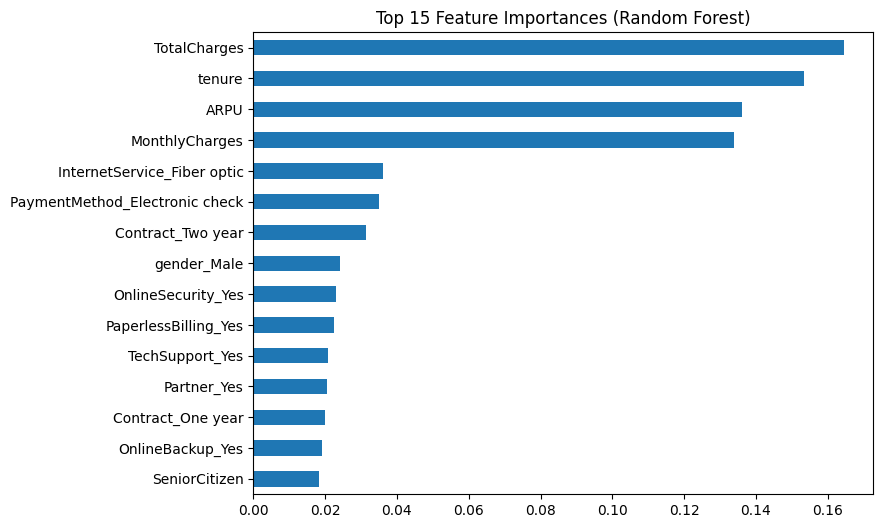

In [4]:
# Q3: Identify key drivers of retention or churn using feature importance, guiding targeted service improvements and marketing strategies.
# prepare encoded dataframe for correlation & modeling
df_proc = df.drop(columns=['customerID']) if 'customerID' in df.columns else df.copy()
# identify categorical columns
cat_cols = [c for c in df_proc.columns if str(df_proc[c].dtype) in ('category','object')]
df_encoded = pd.get_dummies(df_proc, columns=cat_cols, drop_first=True)


print("Encoded shape:", df_encoded.shape)

# correlations with churn
corrs = df_encoded.corr()['Churn'].sort_values(ascending=False)
print("Top positive correlations with churn:\n", corrs.head(10))
print("\nTop negative correlations with churn:\n", corrs.tail(10))

# Random Forest feature importance
from sklearn.ensemble import RandomForestClassifier
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
importances.head(15).sort_values().plot(kind='barh')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()


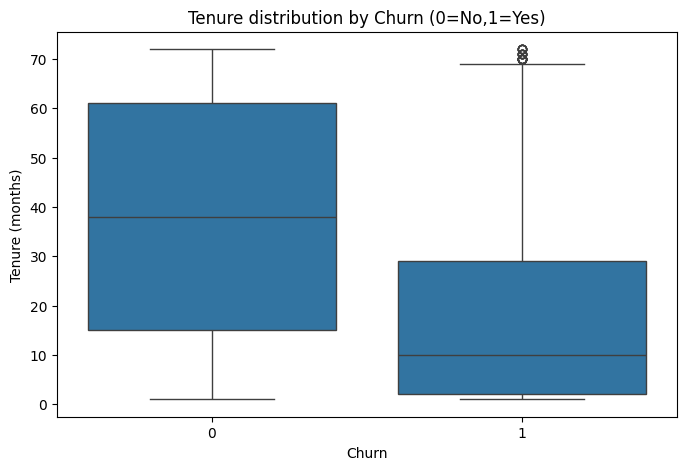

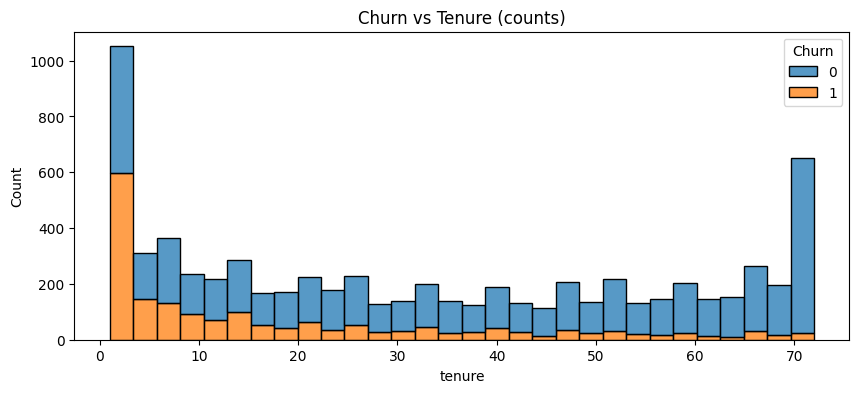

Tenure months with highest churn rate:
    tenure     Churn
0        1  0.619902
1        2  0.516807
4        5  0.481203
3        4  0.471591
2        3  0.470000
6        7  0.389313
9       10  0.387931
8        9  0.386555
14      15  0.373737
5        6  0.363636


In [5]:
# Q4: Determine the point in the customer journey where churn risk peaks to enable timely retention campaigns.
# Distribution of tenure by churn status
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure distribution by Churn (0=No,1=Yes)')
plt.xlabel('Churn')
plt.ylabel('Tenure (months)')
plt.show()

# Histogram
plt.figure(figsize=(10,4))
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, kde=False, stat='count', multiple='stack')
plt.title('Churn vs Tenure (counts)')
plt.show()

# churn rate by tenure and top churn months
churn_by_tenure = df.groupby('tenure')['Churn'].mean().reset_index()
print("Tenure months with highest churn rate:")
print(churn_by_tenure.sort_values('Churn', ascending=False).head(10))


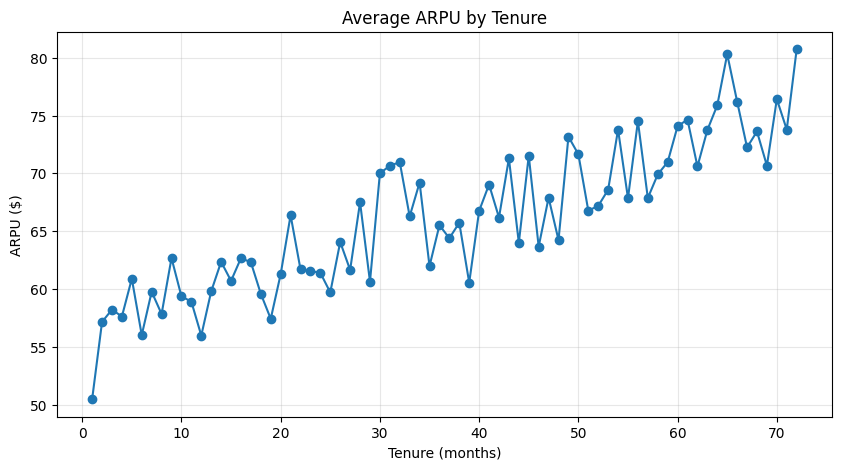

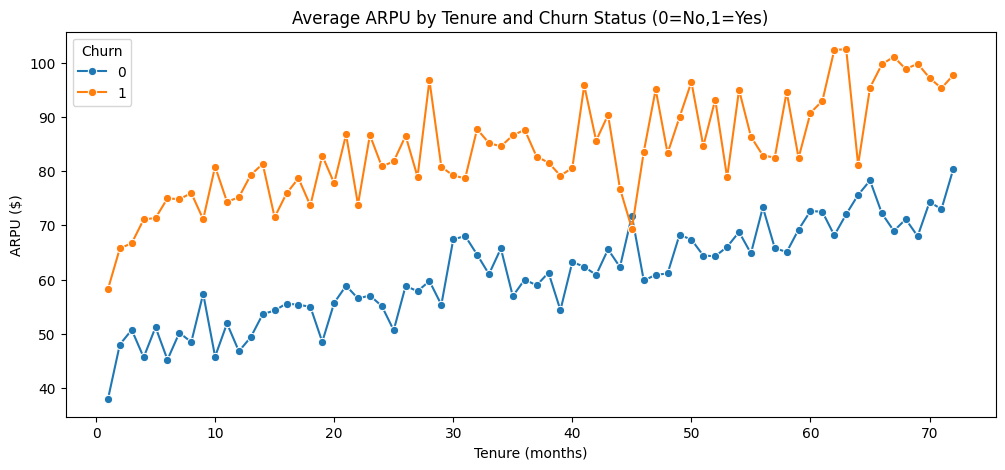

ARPU by Contract:
 Contract
Month-to-month    66.376101
One year          65.108057
Two year          60.903915
Name: ARPU, dtype: float64


/tmp/ipython-input-1014521452.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  arpu_contract = df.groupby('Contract')['ARPU'].mean().sort_values(ascending=False)


In [6]:
# Q5: Track ARPU trends over time to evaluate revenue health and detect pricing or usage issues.
# ARPU overall trend by tenure, and ARPU by churn status
arpu_by_tenure = df.groupby('tenure')['ARPU'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(arpu_by_tenure['tenure'], arpu_by_tenure['ARPU'], marker='o')
plt.title('Average ARPU by Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('ARPU ($)')
plt.grid(alpha=0.3)
plt.show()

# ARPU by tenure & churn
arpu_tenure_churn = df.groupby(['tenure','Churn'])['ARPU'].mean().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(data=arpu_tenure_churn, x='tenure', y='ARPU', hue='Churn', marker='o')
plt.title('Average ARPU by Tenure and Churn Status (0=No,1=Yes)')
plt.xlabel('Tenure (months)')
plt.ylabel('ARPU ($)')
plt.show()

# ARPU by contract type
arpu_contract = df.groupby('Contract')['ARPU'].mean().sort_values(ascending=False)
print("ARPU by Contract:\n", arpu_contract)


/tmp/ipython-input-1298778305.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_arpu = df.groupby(['Contract','InternetService'])['ARPU'].mean().reset_index()
/tmp/ipython-input-1298778305.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=segment_arpu, x='ARPU', y='Segment', palette='viridis')


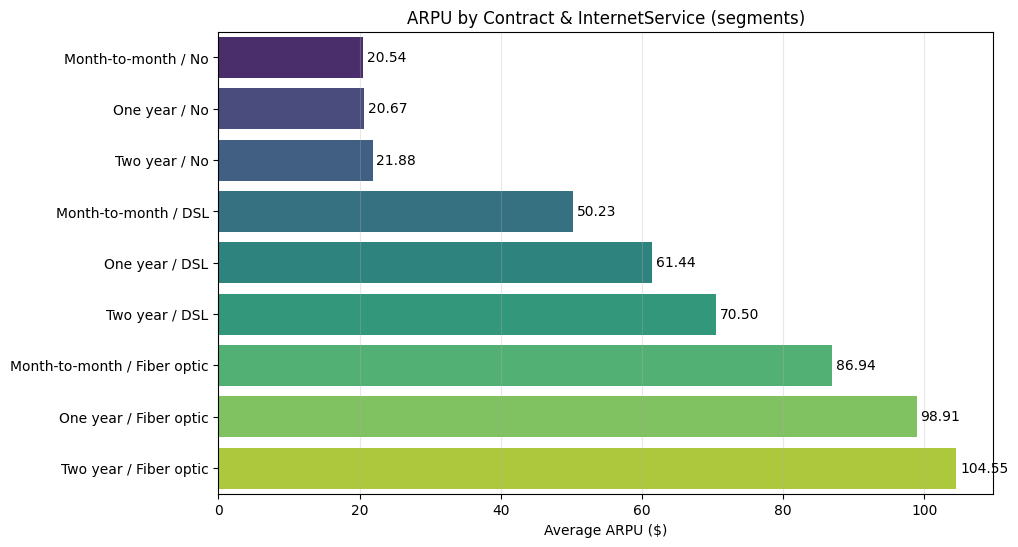

Top 10 segments by ARPU:
      Contract InternetService       ARPU                      Segment
      Two year     Fiber optic 104.549014       Two year / Fiber optic
      One year     Fiber optic  98.910966       One year / Fiber optic
Month-to-month     Fiber optic  86.939675 Month-to-month / Fiber optic
      Two year             DSL  70.501556               Two year / DSL
      One year             DSL  61.440812               One year / DSL
Month-to-month             DSL  50.234345         Month-to-month / DSL
      Two year              No  21.878516                Two year / No
      One year              No  20.674343                One year / No
Month-to-month              No  20.540375          Month-to-month / No


In [7]:
# Q6: Identify the most profitable customer segments to focus acquisition and retention efforts for maximum ROI.
# Top segments by ARPU (Contract + InternetService)
segment_arpu = df.groupby(['Contract','InternetService'])['ARPU'].mean().reset_index()
segment_arpu['Segment'] = segment_arpu['Contract'].astype(str) + " / " + segment_arpu['InternetService'].astype(str)
segment_arpu = segment_arpu.sort_values('ARPU', ascending=True)

plt.figure(figsize=(10,6))
ax = sns.barplot(data=segment_arpu, x='ARPU', y='Segment', palette='viridis')
for i, (v,s) in enumerate(zip(segment_arpu['ARPU'], segment_arpu['Segment'])):
    ax.text(v + 0.5, i, f"{v:.2f}", va='center')
plt.title('ARPU by Contract & InternetService (segments)')
plt.xlabel('Average ARPU ($)')
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)
plt.show()

# show top 10 profitable segments table
print("Top 10 segments by ARPU:")
print(segment_arpu.sort_values('ARPU', ascending=False).head(10).to_string(index=False))

After SMOTE training class counts:
 Churn
0    4130
1    4130
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:30:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84      1033
           1       0.55      0.57      0.56       374

    accuracy                           0.76      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.76      0.76      0.76      1407

ROC AUC: 0.8075694591838318


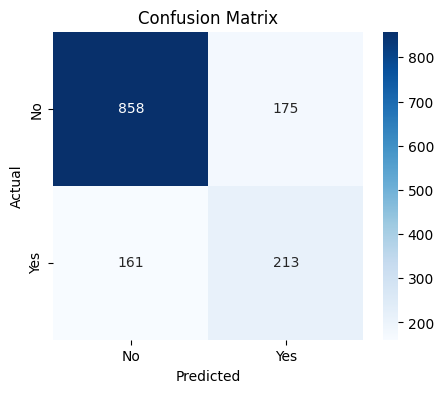

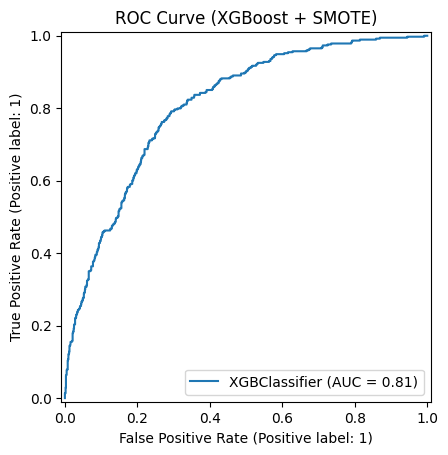

Top 15 XGBoost features:
PaymentMethod_Electronic check           0.245710
InternetService_Fiber optic              0.110697
Contract_Two year                        0.073843
MultipleLines_No phone service           0.053719
PaperlessBilling_Yes                     0.041813
InternetService_No                       0.041598
Contract_One year                        0.041452
PaymentMethod_Credit card (automatic)    0.039626
tenure                                   0.038909
PaymentMethod_Mailed check               0.036706
StreamingMovies_Yes                      0.034051
StreamingTV_Yes                          0.033637
MultipleLines_Yes                        0.033578
PhoneService_Yes                         0.029432
DeviceProtection_Yes                     0.017722
dtype: float32


In [8]:
# Q7: Use predictive modeling to flag customers likely to churn so retention teams can proactively engage them.
# ML pipeline: SMOTE + XGBoost
!pip install -q xgboost imbalanced-learn

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, precision_recall_curve
import matplotlib.pyplot as plt

df_proc = df.drop(columns=['customerID']) if 'customerID' in df.columns else df.copy()
cat_cols = [c for c in df_proc.columns if str(df_proc[c].dtype) in ('category','object')]
df_encoded = pd.get_dummies(df_proc, columns=cat_cols, drop_first=True)

X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Apply SMOTE to training data only
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("After SMOTE training class counts:\n", pd.Series(y_train_sm).value_counts())

# Train XGBoost
xgb = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
xgb.fit(X_train_sm, y_train_sm)

# Predict & evaluate
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:,1]

print("Classification report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.title('ROC Curve (XGBoost + SMOTE)')
plt.show()

# print top features from XGBoost
feat_imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 15 XGBoost features:")
print(feat_imp.head(15))



Q8: Top 10 Customers by Predicted Churn Probability:

customerID  Churn_Probability
8779-QRDMV           0.975578
2012-NWRPA           0.975536
6861-XWTWQ           0.974265
5178-LMXOP           0.966368
9300-AGZNL           0.963142
9497-QCMMS           0.962172
0295-PPHDO           0.959581
4910-GMJOT           0.959387
0897-FEGMU           0.957758
6702-OHFWR           0.957667


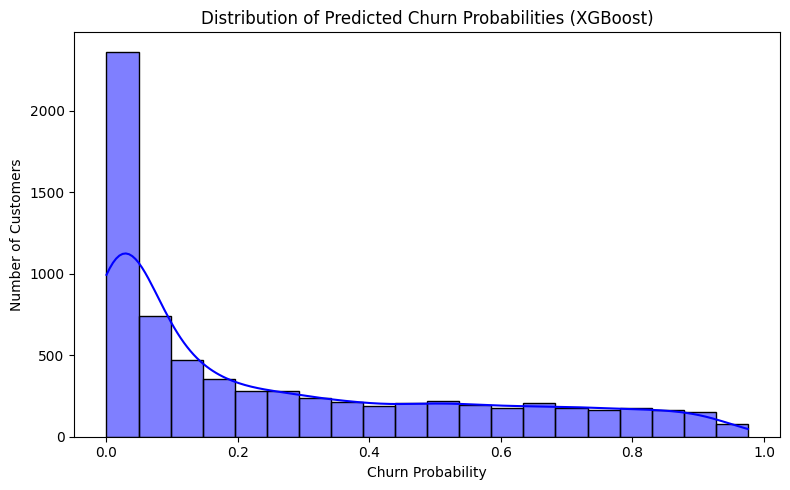

In [9]:
# Q8: Predict individual churn probabilities to personalize offers and retention strategies at the customer level.
# Predict Future Churn Probability for Each Customer (XGBoost - Refined)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

df_model = df.copy()

# Encode target variable
df_model['Churn'] = df_model['Churn'].replace({'Yes': 1, 'No': 0})
df_model['Churn'] = df_model['Churn'].astype(float)
df_model = df_model.dropna(subset=['Churn'])


# Encode categorical columns
label_encoders = {}
for col in df_model.select_dtypes(include=['object', 'category']).columns:
    if col != 'customerID':
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le

# Features & target
X = df_model.drop(['customerID', 'Churn'], axis=1)
y = df_model['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Predict churn probability for all customers
df['Churn_Probability'] = xgb_model.predict_proba(X)[:, 1]

# Show top 10 customers with highest churn probability
q8_table = df[['customerID', 'Churn_Probability']] \
    .sort_values('Churn_Probability', ascending=False)

print("\nQ8: Top 10 Customers by Predicted Churn Probability:\n")
print(q8_table.head(10).to_string(index=False))

# Plot probability distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Churn_Probability'], bins=20, kde=True, color='blue')
plt.title('Distribution of Predicted Churn Probabilities (XGBoost)')
plt.xlabel('Churn Probability')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


In [10]:
# Q9: Identify high-value customers at risk and estimate projected revenue loss to prioritize retention resources effectively.
# Identify high-value at-risk customers and calculate projected revenue loss

# Define churn probability threshold
threshold = 0.7
high_risk_customers = df[df['Churn_Probability'] > threshold].copy()

# Calculate ARPU (Average Revenue Per User)
high_risk_customers['ARPU'] = high_risk_customers['ARPU'].fillna(high_risk_customers['MonthlyCharges'])

max_tenure = df['tenure'].max()
high_risk_customers['RemainingMonths'] = max_tenure - high_risk_customers['tenure']

# Calculate projected loss for each customer over their remaining lifetime
high_risk_customers['ProjectedLoss'] = high_risk_customers['ARPU'] * high_risk_customers['RemainingMonths']

high_risk_customers = high_risk_customers.sort_values(
    by=['ProjectedLoss', 'Churn_Probability'], ascending=False
)

# Display top 10 high-value at-risk customers
top_10_high_risk = high_risk_customers[['customerID', 'ARPU', 'Churn_Probability', 'RemainingMonths', 'ProjectedLoss']].head(10)

# Calculate total projected lifetime revenue loss from customers
total_projected_loss = high_risk_customers['ProjectedLoss'].sum()

print("\nTop 10 High-Value At-Risk Customers:")
print(top_10_high_risk)

print(f"\nTotal Projected Lifetime Revenue Loss (All High-Risk Customers): ${total_projected_loss:,.2f}")



Top 10 High-Value At-Risk Customers:
      customerID        ARPU  Churn_Probability  RemainingMonths  \
171   1875-QIVME  121.400000           0.751325               70   
3159  5150-ITWWB  111.916667           0.800209               69   
6894  1400-MMYXY  111.550000           0.875829               69   
2797  6023-YEBUP  109.983333           0.834263               69   
1401  5419-CONWX  110.712500           0.833874               68   
3085  5052-PNLOS  107.750000           0.818206               69   
1176  3992-YWPKO  111.575000           0.787145               66   
2246  7181-BQYBV  102.450000           0.879768               71   
4738  2369-UAPKZ  108.380000           0.702123               67   
5549  0329-GTIAJ  105.100000           0.814300               69   

      ProjectedLoss  
171         8498.00  
3159        7722.25  
6894        7696.95  
2797        7588.85  
1401        7528.45  
3085        7434.75  
1176        7363.95  
2246        7273.95  
4738        726


Q10: Top 10 Customers by Predicted CLV:

      customerID        ARPU  Predicted_Retention_Months  Predicted_CLV
4586  7569-NMZYQ  120.450694                        60.0    7227.041667
6768  9739-JLPQJ  120.418056                        60.0    7225.083333
5347  9788-HNGUT  119.366667                        60.0    7162.000000
5558  0675-NCDYU  118.656250                        60.0    7119.375000
2368  6650-BWFRT  118.465278                        60.0    7107.916667
2603  0164-APGRB  118.009722                        60.0    7080.583333
5819  3396-DKDEL  117.857143                        60.0    7071.428571
2025  1488-PBLJN  117.745833                        60.0    7064.750000
850   6007-TCTST  117.729167                        60.0    7063.750000
437   4376-KFVRS  117.613889                        60.0    7056.833333


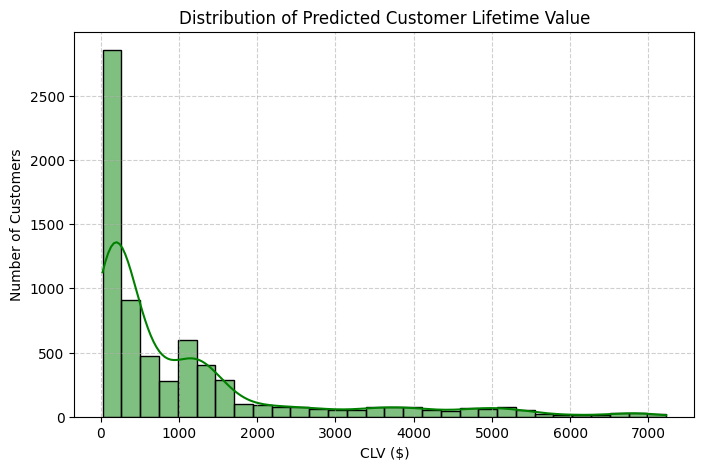

In [11]:
# Q10: Estimate Customer Lifetime Value (CLV) using churn probability to guide long-term revenue forecasting and customer investment strategies.
# Customer Lifetime Value (CLV) Prediction

import matplotlib.pyplot as plt
import seaborn as sns

df_clv = df.copy()

if 'ARPU' not in df_clv.columns:
    df_clv['ARPU'] = df_clv['MonthlyCharges']

if 'Churn_Probability' not in df_clv.columns:
    raise ValueError("Churn_Probability not found. Please run Q8 before Q10.")

# Predict expected retention months from churn probability
# Formula: Expected retention ≈ 1 / churn probability
# Capped at 60 months (~5 years)
df_clv['Predicted_Retention_Months'] = (1 / df_clv['Churn_Probability']).clip(upper=60)

# Calculate CLV: ARPU × Predicted Retention
df_clv['Predicted_CLV'] = df_clv['ARPU'] * df_clv['Predicted_Retention_Months']

# Top 10 customers by CLV
top_clv = df_clv[['customerID', 'ARPU', 'Predicted_Retention_Months', 'Predicted_CLV']] \
    .sort_values('Predicted_CLV', ascending=False)

print("\nQ10: Top 10 Customers by Predicted CLV:\n")
print(top_clv.head(10))

# Plot CLV distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_clv['Predicted_CLV'], bins=30, kde=True, color='green')
plt.title('Distribution of Predicted Customer Lifetime Value')
plt.xlabel('CLV ($)')
plt.ylabel('Number of Customers')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [12]:
# Save cleaned dataset to CSV
clean_path = "/content/clean_churn_dataset.csv"
df.to_csv(clean_path, index=False)

print(f"✅ Clean dataset saved at: {clean_path}")


✅ Clean dataset saved at: /content/clean_churn_dataset.csv


In [13]:
#from google.colab import files
#files.download(clean_path)
